# Numerical Verification of Scale Factor Methodology

This notebook provides a numerical verification of the analytical weights derived in the methodology document. We will use **Monte Carlo simulation** to demonstrate that the single scale factor $f$ calculated using the analytical weights yields the same Expected Positive Value (EPV) as the piecewise scaling function $S(u)$.

## 1. Analytical Weight Calculation

First, let's calculate the theoretical weights $w_{65}, w_{80}, w_{95}$ using numerical integration, as defined in the methodology.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad

def calculate_analytical_weights():
    # Denominator: Base Expected Positive Value (Standard Normal)
    E_total = norm.pdf(0)

    # Helper: Quantile Function
    q = norm.ppf

    # Helper: Linear Interpolation Integrand
    def integrand(u, u_start, width, weight_type):
        factor = (u - u_start) / width if weight_type == 'rising' else ((u_start + width) - u) / width
        return factor * q(u)

    # --- Omega 65 ---
    o65_1, _ = quad(q, 0.50, 0.65)
    o65_2, _ = quad(integrand, 0.65, 0.80, args=(0.65, 0.15, 'falling'))
    w_65 = (o65_1 + o65_2) / E_total

    # --- Omega 80 ---
    o80_1, _ = quad(integrand, 0.65, 0.80, args=(0.65, 0.15, 'rising'))
    o80_2, _ = quad(integrand, 0.80, 0.95, args=(0.80, 0.15, 'falling'))
    w_80 = (o80_1 + o80_2) / E_total

    # --- Omega 95 ---
    o95_1, _ = quad(integrand, 0.80, 0.95, args=(0.80, 0.15, 'rising'))
    o95_2, _ = quad(q, 0.95, 1.00)
    w_95 = (o95_1 + o95_2) / E_total

    return w_65, w_80, w_95

w65, w80, w95 = calculate_analytical_weights()
print(f"Analytical Weights:")
print(f"w_65: {w65:.4%}")
print(f"w_80: {w80:.4%}")
print(f"w_95: {w95:.4%}")
print(f"Sum:  {w65+w80+w95:.4%}")

Analytical Weights:
w_65: 17.0682%
w_80: 32.5042%
w_95: 50.4275%
Sum:  100.0000%


## 2. Monte Carlo Simulation

Now we simulate a large number of draws from a Standard Normal distribution. 

1. Generate $N$ samples $X \sim \mathcal{N}(0, 1)$.
2. Calculate their percentiles $U = \Phi(X)$.
3. Apply the piecewise scaling function $S(U)$ to get $X_{scaled}$.
4. Compute the average positive value of $X_{scaled}$.

In [7]:
# --- Parameters (Try changing these!) ---
N_SAMPLES = 1_000_000
F_65 = 2
F_80 = 1.0
F_95 = 2
# ----------------------------------------

def run_simulation(n_samples, f65, f80, f95):
    # 1. Generate samples
    X = np.random.normal(0, 1, n_samples)
    
    # 2. Calculate percentiles (CDF)
    U = norm.cdf(X)
    
    # 3. Calculate Scale Factors S(U)
    # Vectorized implementation of the piecewise function
    S = np.ones_like(X) # Default to 1 (though we only care about > 0.5 for EPV)
    
    # Region 1: 0.50 < u <= 0.65
    mask1 = (U > 0.50) & (U <= 0.65)
    S[mask1] = f65
    
    # Region 2: 0.65 < u <= 0.80
    mask2 = (U > 0.65) & (U <= 0.80)
    S[mask2] = f65 + (f80 - f65) * (U[mask2] - 0.65) / 0.15
    
    # Region 3: 0.80 < u <= 0.95
    mask3 = (U > 0.80) & (U <= 0.95)
    S[mask3] = f80 + (f95 - f80) * (U[mask3] - 0.80) / 0.15
    
    # Region 4: 0.95 < u <= 1.00
    mask4 = (U > 0.95)
    S[mask4] = f95
    
    # 4. Apply Scaling
    X_scaled = X * S
    
    # 5. Calculate EPV (Expected Positive Value)
    # We take the mean of max(0, X_scaled)
    epv_simulated = np.mean(np.maximum(0, X_scaled))
    
    return epv_simulated, X, X_scaled, S

print(f"Running simulation with {N_SAMPLES:,} samples...")
epv_sim, X_data, X_scaled_data, S_data = run_simulation(N_SAMPLES, F_65, F_80, F_95)

# Calculate Analytical Prediction
f_analytical = w65 * F_65 + w80 * F_80 + w95 * F_95
epv_analytical = f_analytical * norm.pdf(0) # f * E[max(0, X_std)]

print(f"\nResults:")
print(f"Analytical Single Factor f: {f_analytical:.6f}")
print(f"Analytical EPV:             {epv_analytical:.6f}")
print(f"Simulated EPV:              {epv_sim:.6f}")
print(f"Difference:                 {abs(epv_sim - epv_analytical):.6f} ({abs(epv_sim - epv_analytical)/epv_analytical:.4%})")

Running simulation with 1,000,000 samples...

Results:
Analytical Single Factor f: 1.674958
Analytical EPV:             0.668211
Simulated EPV:              0.668752
Difference:                 0.000540 (0.0809%)


## 3. Visualization

### 3.1 Distribution Comparison
Let's look at the tail of the distribution (Positive values) to see how the scaling affects the shape.

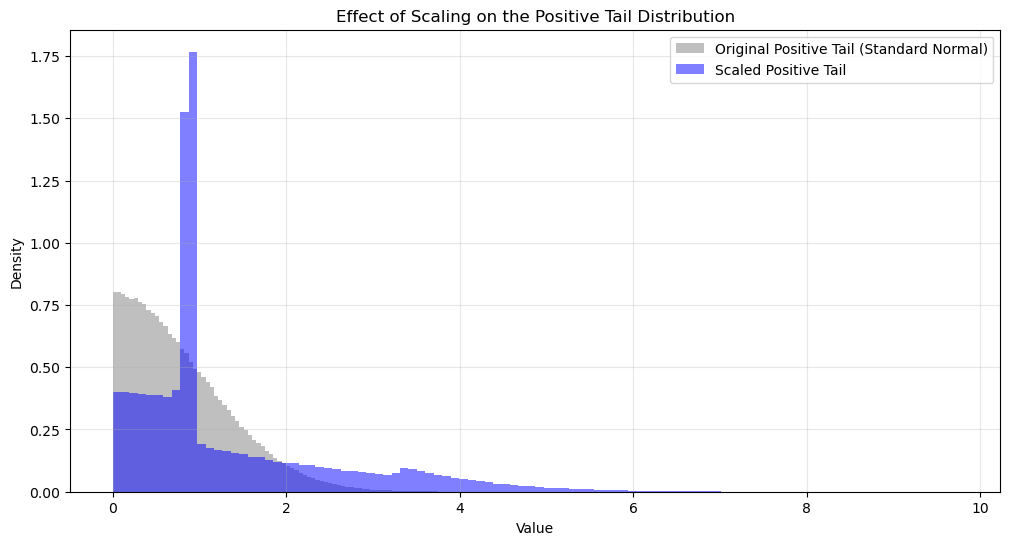

In [8]:
plt.figure(figsize=(12, 6))

# Filter for positive values only for the plot
pos_mask = X_data > 0
x_pos = X_data[pos_mask]
x_scaled_pos = X_scaled_data[pos_mask]

plt.hist(x_pos, bins=100, alpha=0.5, label='Original Positive Tail (Standard Normal)', density=True, color='gray')
plt.hist(x_scaled_pos, bins=100, alpha=0.5, label='Scaled Positive Tail', density=True, color='blue')

plt.title('Effect of Scaling on the Positive Tail Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 3.2 Convergence Check
To be sure our simulation result isn't a fluke, let's see how the Simulated EPV converges to the Analytical EPV as we process more samples.

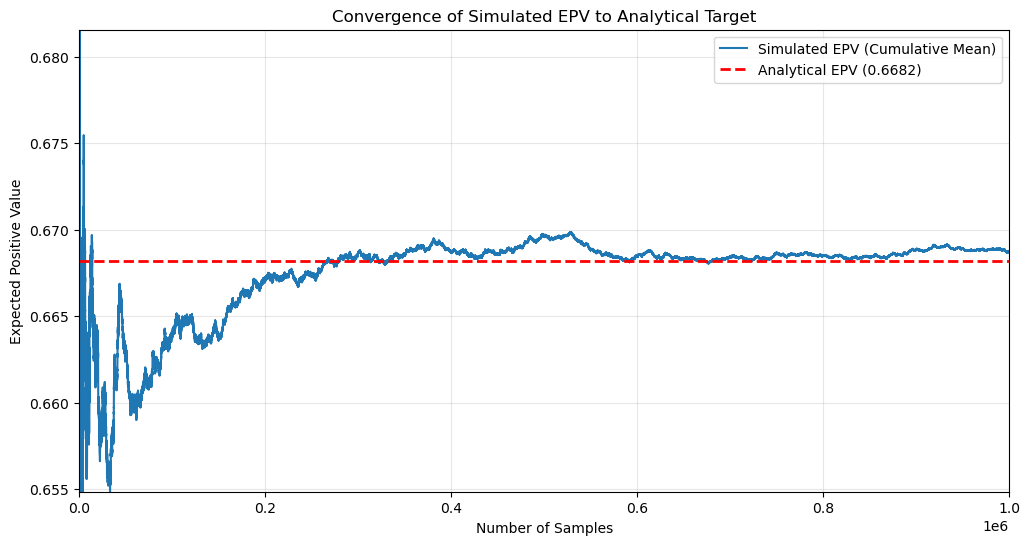

In [9]:
# Compute cumulative mean of the positive scaled values
pos_vals = np.maximum(0, X_scaled_data)
cumulative_means = np.cumsum(pos_vals) / np.arange(1, N_SAMPLES + 1)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_means, label='Simulated EPV (Cumulative Mean)', color='#1f77b4')
plt.axhline(y=epv_analytical, color='red', linestyle='--', label=f'Analytical EPV ({epv_analytical:.4f})', linewidth=2)

# Zoom in on the last 20% of samples to show stability
plt.xlim(0, N_SAMPLES)
plt.ylim(epv_analytical * 0.98, epv_analytical * 1.02)

plt.title('Convergence of Simulated EPV to Analytical Target')
plt.xlabel('Number of Samples')
plt.ylabel('Expected Positive Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()